In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt
#https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook  (cross validation)'

#http://localhost:8888/lab/tree/MyQuantFinProject/AlgoTradingProject/ML-S50F/Lab-S50F_XGBoost/S50F-XGB_Model/V2_LS_PredictNewData.ipynb
#https://xgboost.readthedocs.io/en/latest/

In [410]:
df=pd.read_csv('data/SET-Daily2009-2022.csv',index_col='Date/Time',parse_dates=['Date/Time'],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2009-01-05 to 2022-10-28
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ticker             3366 non-null   object 
 1   MACD               3366 non-null   float64
 2   TrendMACD          3366 non-null   float64
 3   SIGNAL             3366 non-null   float64
 4   TrendSIGNAL        3366 non-null   float64
 5   Trend_MACD_SIGNAL  3366 non-null   float64
 6   RSI                3366 non-null   float64
 7   TrendRSI           3366 non-null   float64
 8   Trend_MACD_RSI     3366 non-null   float64
 9   Close              3366 non-null   float64
 10  MiddleHL           3366 non-null   float64
 11  Close-MiddleHL     3366 non-null   float64
dtypes: float64(11), object(1)
memory usage: 341.9+ KB


In [411]:
#df=df[['MACD','SIGNAL','RSI','Trend_MACD_SIGNAL','Trend_MACD_RSI']]
df=df[['MACD','SIGNAL','RSI','Close']]
print(df.info())
df.tail(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2009-01-05 to 2022-10-28
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MACD    3366 non-null   float64
 1   SIGNAL  3366 non-null   float64
 2   RSI     3366 non-null   float64
 3   Close   3366 non-null   float64
dtypes: float64(4)
memory usage: 131.5 KB
None


,MACD,SIGNAL,RSI,Close
Date/Time,,,,
2022-10-21,-6.76,-9.34,47.48,1591.32
2022-10-25,-4.77,-8.77,51.32,1600.66
2022-10-26,-3.57,-8.12,49.57,1596.46
2022-10-27,-2.12,-7.37,52.01,1602.33
2022-10-28,-0.68,-6.53,53.55,1606.07


C:\Users\pongthsa\AppData\Local\Temp\ipykernel_3612\2677952517.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3=plt.subplot(312,sharex = ax1)


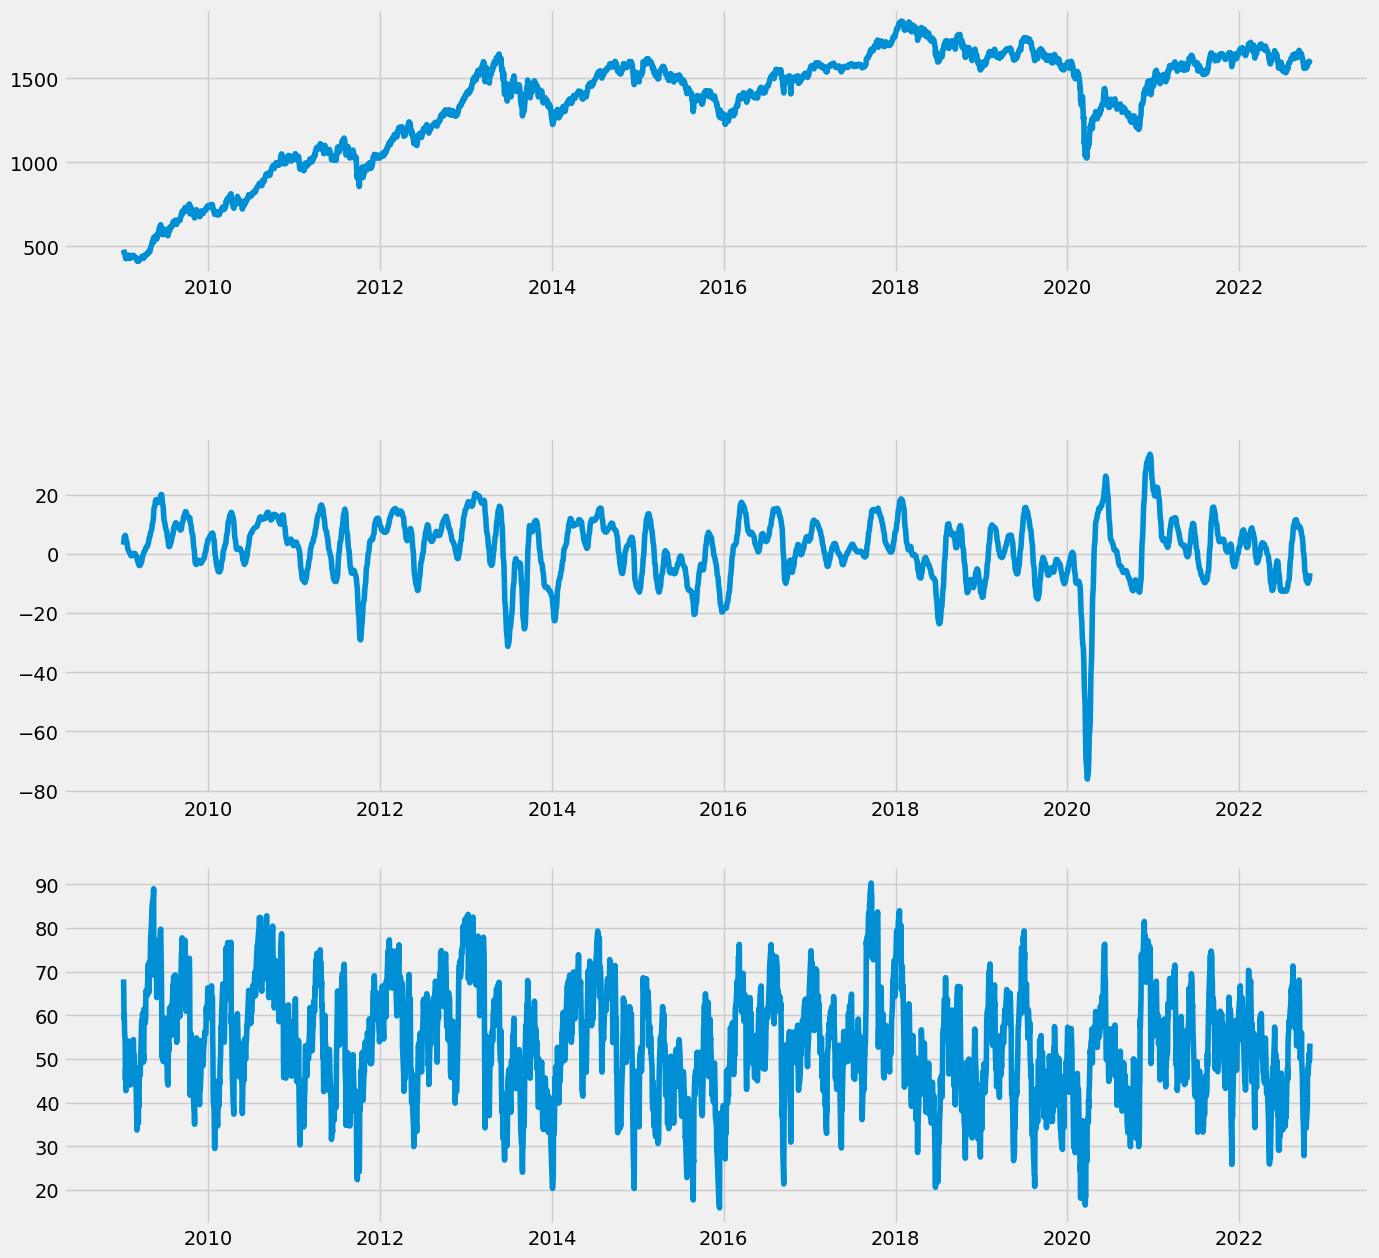

In [412]:
plt.figure(figsize=(15,15))

ax1=plt.subplot(411)
plt.plot(df['Close'],label='Close')


ax2=plt.subplot(412,sharex = ax1)
plt.plot(df['MACD'],label='MACD')


ax3=plt.subplot(312,sharex = ax1)
plt.plot(df['SIGNAL'],label='SIGNAL')


ax4=plt.subplot(313,sharex = ax1)
plt.plot(df['RSI'],label='RSI')

plt.show()

In [413]:
df=df[['MACD','SIGNAL','RSI']]
df=df.loc[:'2022-12-31',:]

SYMBOL='SET'
TARGET='MACD'
PREDICT_TARGET=f'{TARGET}-PREDICT'

Mid_TARGET=0
FEATURES=[  x for x in df.columns.tolist()  if x!=TARGET]

print(FEATURES)
print(TARGET)

['SIGNAL', 'RSI']
MACD


In [414]:
end_period_train='2021-12-31' # start to test

start_period_test='2022-01-01'
end_period_test='2022-06-30'

unseen_period='2022-07'

train = df.loc[:end_period_train,:]
print(train.tail())
test = df.loc[start_period_test:end_period_test,:]
print(test.tail())

unseen=df.loc[unseen_period:,:]
print(unseen.tail())





            MACD  SIGNAL    RSI
Date/Time                      
2021-12-24  3.24   -0.22  54.50
2021-12-27  3.56    0.25  54.21
2021-12-28  4.17    0.74  56.00
2021-12-29  5.57    1.34  59.94
2021-12-30  6.88    2.04  61.29
             MACD  SIGNAL    RSI
Date/Time                       
2022-06-24 -18.14  -11.94  37.04
2022-06-27 -16.18  -12.47  41.62
2022-06-28 -13.22  -12.56  46.79
2022-06-29 -11.51  -12.43  44.35
2022-06-30 -11.60  -12.33  39.58
            MACD  SIGNAL    RSI
Date/Time                      
2022-10-21 -6.76   -9.34  47.48
2022-10-25 -4.77   -8.77  51.32
2022-10-26 -3.57   -8.12  49.57
2022-10-27 -2.12   -7.37  52.01
2022-10-28 -0.68   -6.53  53.55


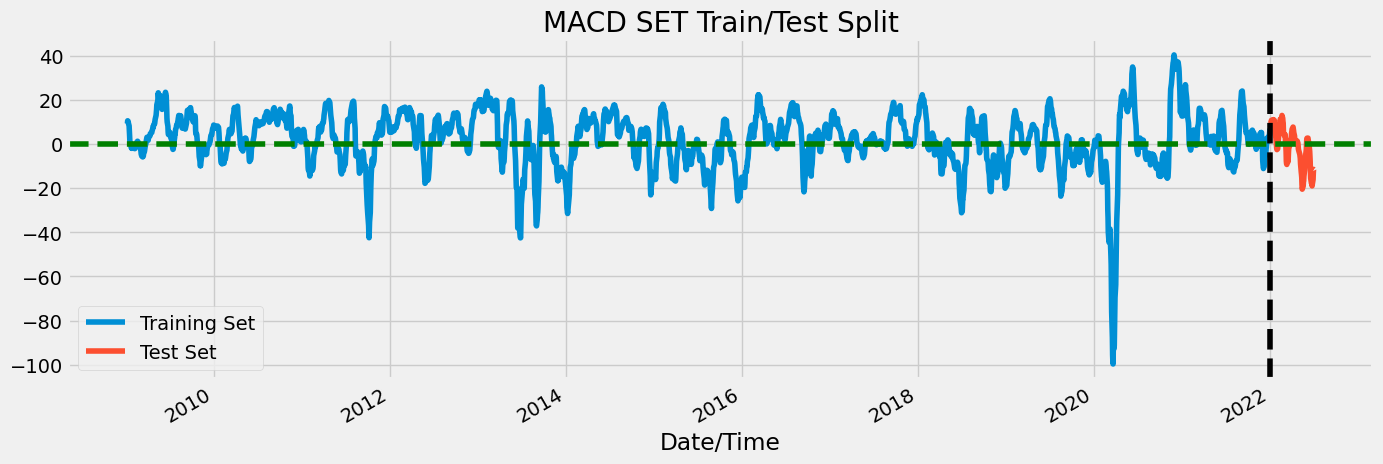

In [415]:
fig, ax = plt.subplots(figsize=(15, 5))
train[TARGET].plot(ax=ax, label='Training Set', title=f'{TARGET} {SYMBOL} Train/Test Split')
test[TARGET].plot(ax=ax, label='Test Set')
ax.axvline(start_period, color='black', ls='--')
ax.axhline(Mid_TARGET, color='green', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [416]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_unseen=unseen[FEATURES]

In [417]:
reg = xgb.XGBRegressor( booster='gbtree',    
                       n_estimators=500,
                       early_stopping_rounds=100,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[23:52:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:12.90247	validation_1-rmse:8.88956
[100]	validation_0-rmse:6.35741	validation_1-rmse:4.84797
[200]	validation_0-rmse:4.08373	validation_1-rmse:3.46525
[300]	validation_0-rmse:3.44066	validation_1-rmse:3.05734
[400]	validation_0-rmse:3.28151	validation_1-rmse:2.94529
[499]	validation_0-rmse:3.22568	validation_1-rmse:2.91448


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

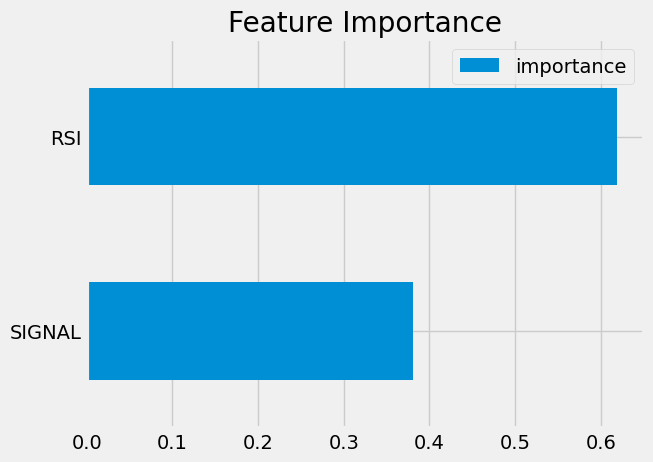

In [418]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [419]:
test[PREDICT_TARGET] = reg.predict(X_test)
df = df.merge(test[[PREDICT_TARGET]], how='left', left_index=True, right_index=True)
print(test.head())
print(test.tail())

             MACD  SIGNAL    RSI  MACD-PREDICT
Date/Time                                     
2022-01-04   8.82    2.88  65.01      8.614326
2022-01-05  10.68    3.86  66.77      9.797584
2022-01-06   9.81    4.60  55.79      3.815096
2022-01-07   9.39    5.20  57.24      5.769913
2022-01-10   8.87    5.66  57.00      5.769913
             MACD  SIGNAL    RSI  MACD-PREDICT
Date/Time                                     
2022-06-24 -18.14  -11.94  37.04    -13.415352
2022-06-27 -16.18  -12.47  41.62    -11.454621
2022-06-28 -13.22  -12.56  46.79     -7.370198
2022-06-29 -11.51  -12.43  44.35     -9.845390
2022-06-30 -11.60  -12.33  39.58    -12.861964


C:\Users\pongthsa\AppData\Local\Temp\ipykernel_3612\3298771559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[PREDICT_TARGET] = reg.predict(X_test)


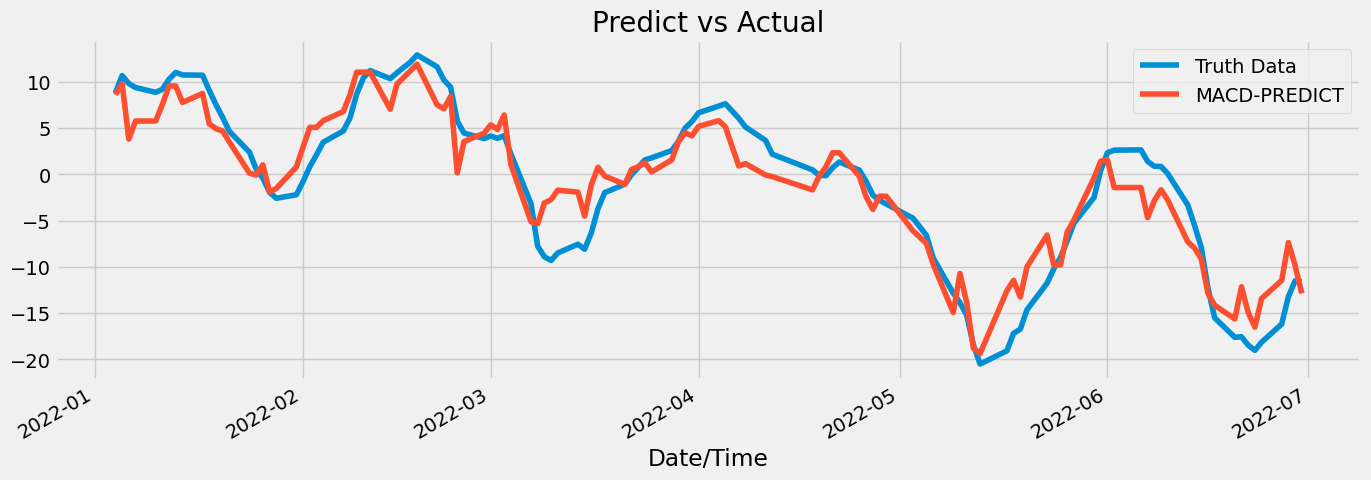

In [420]:
ax = df.loc[start_period_test:end_period_test][TARGET] .plot(figsize=(15, 5), title='Predict vs Actual')
df.loc[ start_period_test:end_period_test][PREDICT_TARGET] .plot(style='-')
plt.legend(['Truth Data',PREDICT_TARGET])
plt.show()

In [421]:
score = np.sqrt(mean_squared_error(test[TARGET], test[PREDICT_TARGET]))
print(f'RMSE Score on Test set: {score:0.2f}')
r2_score = np.sqrt(r2_score(test[TARGET], test[PREDICT_TARGET]))
print(f'R2 Score on Test set: {r2_score :0.2f}')
test['error'] = np.abs(test[TARGET] - test[PREDICT_TARGET])
test['date'] = test.index.date
diff_actual_prediction=test.groupby(['date'])['error'].mean()
diff_actual_prediction.tail(10)

RMSE Score on Test set: 2.91
R2 Score on Test set: 0.94


date
2022-06-17    1.359621
2022-06-20    1.982096
2022-06-21    5.409541
2022-06-22    3.537867
2022-06-23    2.510784
2022-06-24    4.724648
2022-06-27    4.725379
2022-06-28    5.849802
2022-06-29    1.664610
2022-06-30    1.261964
Name: error, dtype: float64

In [422]:
X_unseen=unseen[FEATURES]
X_unseen[PREDICT_TARGET] = reg.predict(X_unseen)
X_unseen.tail()

,SIGNAL,RSI,MACD-PREDICT
Date/Time,,,
2022-10-21,-9.34,47.48,-6.245339
2022-10-25,-8.77,51.32,-2.465596
2022-10-26,-8.12,49.57,-4.627690
2022-10-27,-7.37,52.01,-2.281362
2022-10-28,-6.53,53.55,-1.369804


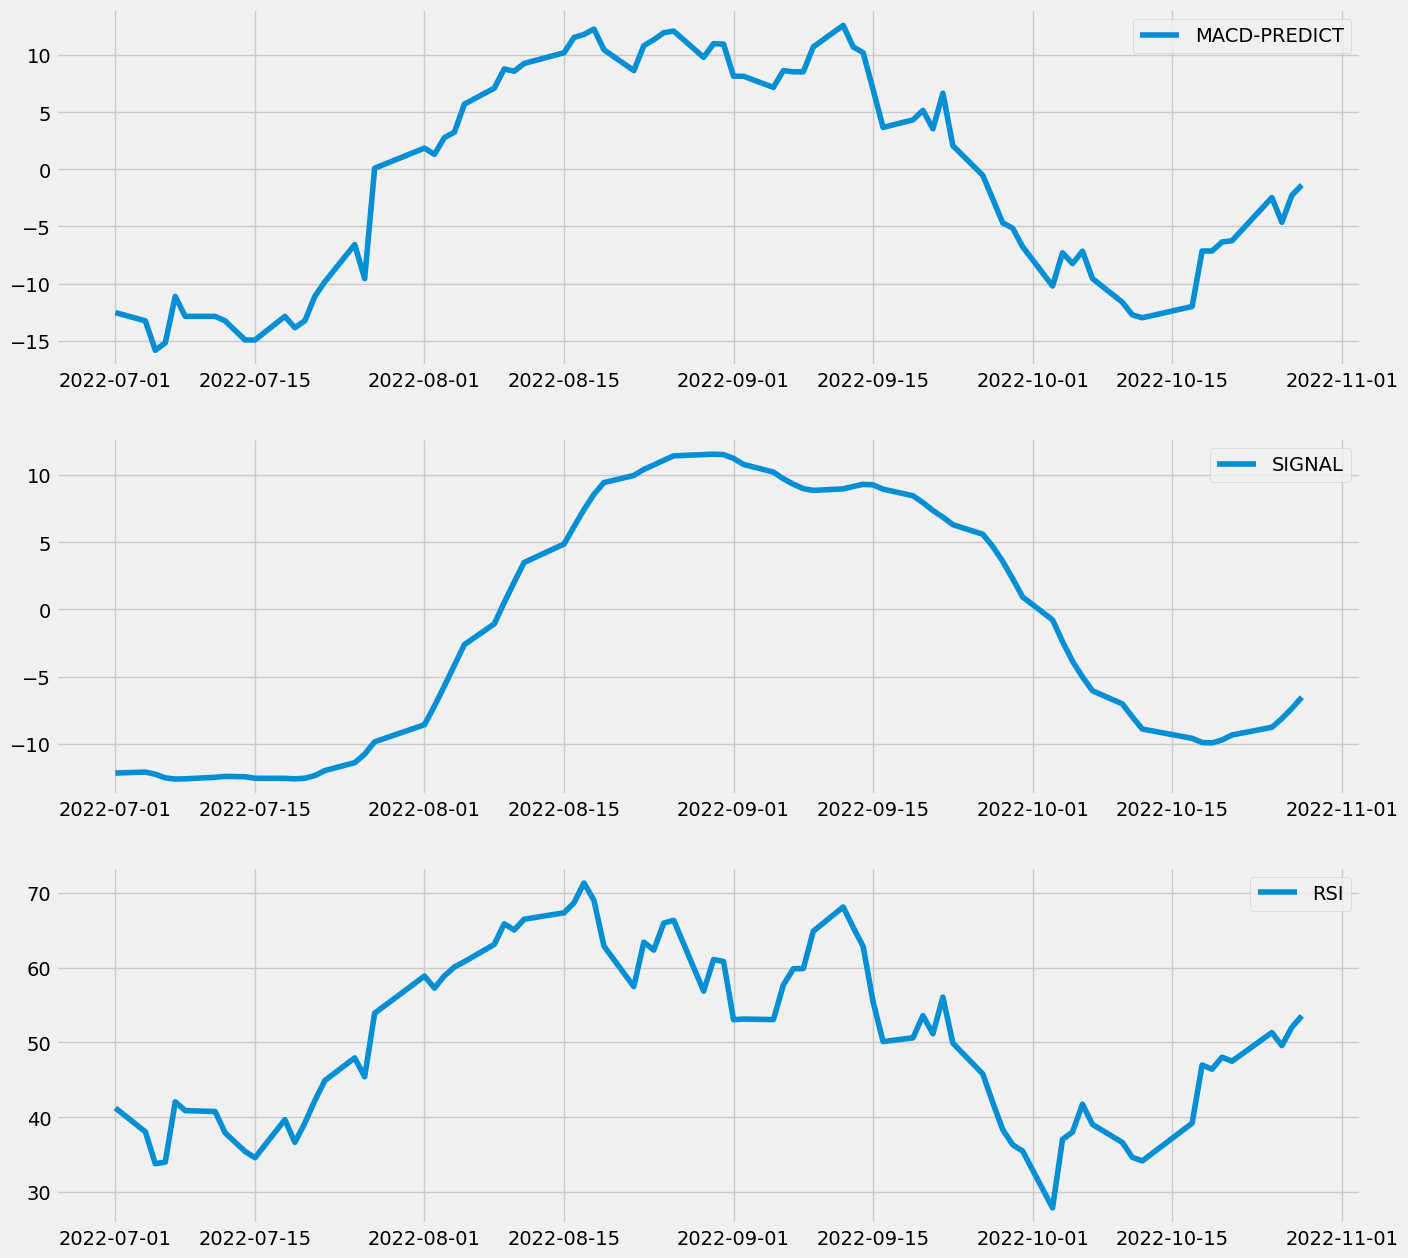

In [423]:
plt.figure(figsize=(15,15))

ax1=plt.subplot(311)
plt.plot(X_unseen[PREDICT_TARGET],label=PREDICT_TARGET)
plt.legend()

plt.subplot(312,sharex = ax1)
plt.plot(X_unseen['SIGNAL'],label='SIGNAL')
plt.legend()

plt.subplot(313,sharex = ax1)
plt.plot(X_unseen['RSI'],label='RSI')
plt.legend()

plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()